In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. 데이터 전처리

In [6]:
#당진, 울산 기상 관측 데이터 DNI 포함
data_dangjin = pd.read_csv('solar_power_mycode/train_dangjin.csv')
data_ulsan = pd.read_csv('solar_power_mycode/train_ulsan.csv')
data_dangjin_1517 = pd.read_csv('solar_power_mycode/dangjin(2015~2018-03-01).csv')

power_dacon = pd.read_csv('solar_power_mycode/dacon_data/energy.csv')
power4_1517 = pd.read_csv('solar_power_mycode/power4_1517.csv')
power4_1819 = pd.read_csv('solar_power_mycode/power4_1819.csv')

In [7]:
weather_dangjin = data_dangjin[['Time',
                             'cos(time)',
                             'GHI(W/m^2)',
                             'Ground_Temperature',
                             'Humidity',
                             'Visibility',
                             'Wind_Speed',
                             'Wind_Direction']]
weather_dangjin_1517 = data_dangjin_1517[['Time',
                                         'cos(time)',
                                         'GHI(W/m^2)',
                                         'Ground_Temperature',
                                         'Humidity',
                                         'Visibility',
                                         'Wind_Speed',
                                         'Wind_Direction']]
weather_ulsan = data_ulsan[['Time',
                             'cos(time)',
                             'GHI(W/m^2)',
                             'Ground_Temperature',
                             'Humidity',
                             'Visibility',
                             'Wind_Speed',
                             'Wind_Direction']]

In [8]:
weather_dataset_temp = pd.concat([weather_dangjin_1517, weather_dangjin], axis=0)

In [9]:
weather_dataset_dangjin = weather_dataset_temp[:np.where(weather_dataset_temp['Time']=='2021-01-01 0:00')[0][0]]
weather_dataset_dangjin

,Time,cos(time),GHI(W/m^2),Ground_Temperature,Humidity,Visibility,Wind_Speed,Wind_Direction
0,2015-01-01 1:00,0.96590,0.0,0.3,47.0,1500.0,5.4,3.400000e+02
1,2015-01-01 2:00,0.86600,0.0,0.3,50.0,NaN,4.9,3.400000e+02
2,2015-01-01 3:00,0.70710,0.0,0.2,50.0,2000.0,6.2,3.200000e+02
3,2015-01-01 4:00,0.50000,0.0,0.2,56.0,2000.0,5.0,3.200000e+02
4,2015-01-01 5:00,0.25880,0.0,0.2,52.0,2000.0,5.5,3.200000e+02
...,...,...,...,...,...,...,...,...
24883,2020-12-31 19:00,0.25882,0.0,-0.3,85.0,668.0,0.8,9.396926e-01
24884,2020-12-31 20:00,0.50000,0.0,-0.5,88.0,1395.0,1.1,-7.660444e-01
24885,2020-12-31 21:00,0.70711,0.0,-0.7,88.0,1036.0,0.5,-7.660444e-01
24886,2020-12-31 22:00,0.86603,0.0,-0.8,89.0,890.0,0.5,1.230000e-16


In [10]:
raw_dangjin_power_1517 = pd.DataFrame()
raw_warehouse_power_1517 = pd.DataFrame()
raw_floating_power_1517 = pd.DataFrame()
raw_ulsan_power_1517 = pd.DataFrame()

for i in range(len(power4_1517['Category'])):
    if power4_1517['Category'][i] == 1:
        raw_dangjin_power_1517 = pd.concat([raw_dangjin_power_1517,power4_1517[i:i+1]])
    elif power4_1517['Category'][i] == 2:
        raw_warehouse_power_1517 = pd.concat([raw_warehouse_power_1517,power4_1517[i:i+1]])
    elif power4_1517['Category'][i] == 3:
        raw_floating_power_1517 = pd.concat([raw_floating_power_1517,power4_1517[i:i+1]])
    elif power4_1517['Category'][i] == 4:
        raw_ulsan_power_1517 = pd.concat([raw_ulsan_power_1517,power4_1517[i:i+1]])
    else:
        pass

In [11]:
dangjin_power_1517 = pd.DataFrame()
warehouse_power_1517 = pd.DataFrame()
floating_power_1517 = pd.DataFrame()
ulsan_power_1517 = pd.DataFrame()
for i in range(raw_dangjin_power_1517.shape[0]):
    dangjin_power_1517 = pd.concat([dangjin_power_1517, raw_dangjin_power_1517.reset_index().iloc[i][6:]], axis=0) 
    warehouse_power_1517 = pd.concat([warehouse_power_1517, raw_warehouse_power_1517.reset_index().iloc[i][6:]], axis=0)
    ulsan_power_1517 = pd.concat([ulsan_power_1517, raw_ulsan_power_1517.reset_index().iloc[i][6:]], axis=0)
dangjin_power_1517.reset_index()
warehouse_power_1517.reset_index()
ulsan_power_1517.reset_index();

In [12]:
raw_dangjin_power_1819 = pd.DataFrame()
raw_warehouse_power_1819 = pd.DataFrame()
raw_floating_power_1819 = pd.DataFrame()
raw_ulsan_power_1819 = pd.DataFrame()

for i in range(len(power4_1819['Category'])):
    if power4_1819['Category'][i] == 1:
        raw_dangjin_power_1819 = pd.concat([raw_dangjin_power_1819,power4_1819[i:i+1]])
    elif power4_1517['Category'][i] == 2:
        raw_warehouse_power_1819 = pd.concat([raw_warehouse_power_1819,power4_1819[i:i+1]])
    elif power4_1517['Category'][i] == 3:
        raw_floating_power_1819 = pd.concat([raw_floating_power_1819,power4_1819[i:i+1]])
    elif power4_1517['Category'][i] == 4:
        raw_ulsan_power_1819 = pd.concat([raw_ulsan_power_1819,power4_1819[i:i+1]])
    else:
        pass

In [13]:
dangjin_power_1819 = pd.DataFrame()
warehouse_power_1819 = pd.DataFrame()
floating_power_1819 = pd.DataFrame()
ulsan_power_1819 = pd.DataFrame()
for i in range(raw_dangjin_power_1819.shape[0]):
    dangjin_power_1819 = pd.concat([dangjin_power_1819, raw_dangjin_power_1819.reset_index().iloc[i][5:]], axis=0) 
    warehouse_power_1819 = pd.concat([warehouse_power_1819, raw_warehouse_power_1819.reset_index().iloc[i][5:]], axis=0)
    ulsan_power_1819 = pd.concat([ulsan_power_1819, raw_ulsan_power_1819.reset_index().iloc[i][5:]], axis=0)
    if raw_dangjin_power_1819['Time'][i] == '2018-02-28':
        break
dangjin_power_1819.reset_index()
warehouse_power_1819.reset_index()
ulsan_power_1819.reset_index();


In [14]:
bound = np.where(power_dacon['time']=='2021-01-01 0:02')[0][0]

In [15]:
power_dataset_1517 = pd.concat([dangjin_power_1517, warehouse_power_1517, ulsan_power_1517], axis = 1)
power_dataset_1517.columns = ['dangjin', 'warehouse', 'ulsan']

power_dataset_1819 = pd.concat([dangjin_power_1819, warehouse_power_1819, ulsan_power_1819], axis = 1)
power_dataset_1819.columns = ['dangjin', 'warehouse', 'ulsan']

bound = np.where(power_dacon['time']=='2021-01-01 0:02')[0][0]
power_dataset_1920 = power_dacon[:bound][['dangjin',
                                         'dangjin_warehouse',
                                         'ulsan']]
power_dataset_1920.rename(columns={'dangjin_warehouse':'warehouse'}, inplace = True)

In [16]:
power_dataset = pd.concat([power_dataset_1517, power_dataset_1819,power_dataset_1920])
power_dataset.astype(float).reset_index()

,index,dangjin,warehouse,ulsan
0,1,0.0,0.0,0.0
1,2,0.0,0.0,0.0
2,3,0.0,0.0,0.0
3,4,0.0,0.0,0.0
4,5,0.0,0.0,0.0
...,...,...,...,...
52603,24883,0.0,0.0,0.0
52604,24884,0.0,0.0,0.0
52605,24885,0.0,0.0,0.0
52606,24886,0.0,0.0,0.0


In [17]:
# dataset from 15-01-01 to 19-12-31
print(weather_dataset_dangjin.shape) # weather dataset including 'Time' feature
print(power_dataset.shape) # dangjin, warehouse, ulsan power data

(52608, 8)
(52608, 3)


In [18]:
raw_data_dangjin = weather_dataset_dangjin[['cos(time)',
                                             'GHI(W/m^2)',
                                             'Ground_Temperature',
                                             'Humidity',
                                             'Visibility',
                                             'Wind_Speed',
                                             'Wind_Direction']]

raw_power_dangjin = power_dataset['dangjin']
raw_power_warehouse = power_dataset['warehouse']
#raw_power_floating
#raw_power_ulsan = power_dataset['ulsan']

raw_data_ulsan = data_ulsan[['cos(time)',
                             'GHI(W/m^2)',
                             'Ground_Temperature',
                             'Humidity',
                             'Visibility',
                             'Wind_Speed',
                             'Wind_Direction']]
raw_power_ulsan = data_ulsan[['Power']]

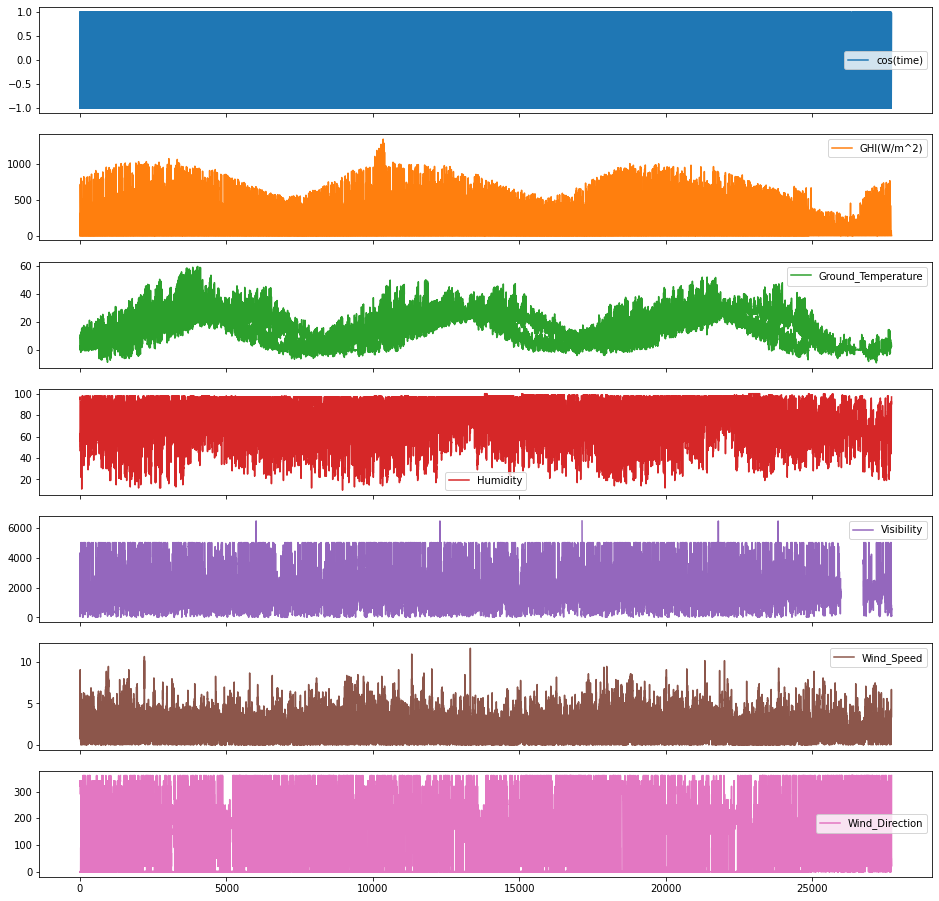

In [19]:
raw_data_dangjin.plot(subplots=True, figsize=(16, 16));

In [20]:
# 이상치 NaN 값으로 변경
for i in range(len(raw_data_dangjin)):
    if raw_data_dangjin['GHI(W/m^2)'][i] > 1000:
        raw_data_dangjin['GHI(W/m^2)'][i] = np.nan
'''
for i in range(len(raw_data_dangjin)):
    if raw_data_dangjin['Visibility'][i] > 5100:
        raw_data_dangjin['Visibility'][i] = np.nan
'''


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [21]:
# NaN 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(raw_data_dangjin.values)
imp_data_dangjin = imputer.transform(raw_data_dangjin.values)

imputer.fit(raw_data_ulsan.values)
imp_data_ulsan = imputer.transform(raw_data_ulsan.values)

imputer.fit(np.expand_dims(raw_power_dangjin, axis=0))
proc_power_dangjin = imputer.transform(np.expand_dims(raw_power_dangjin, axis=0))

imputer.fit(np.expand_dims(raw_power_warehouse, axis=0))
proc_power_warehouse = imputer.transform(np.expand_dims(raw_power_warehouse, axis=0))



In [22]:
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_data_dangjin).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_data_ulsan).flatten()))


데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0


In [23]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scipy as sp
import scipy.stats
scaler = MinMaxScaler()
scaler.fit(imp_data_dangjin)
scaler.fit(imp_data_ulsan)
imp_data_dangjin_scaled = scaler.transform(imp_data_dangjin)
imp_data_ulsan_scaled = scaler.transform(imp_data_ulsan)
proc_data_dangjin = pd.DataFrame(data=imp_data_dangjin_scaled, 
                                 columns=['cos(time)',
                                         'GHI(W/m^2)',
                                         'Ground_Temperature',
                                         'Humidity',
                                         'Visibility',
                                         'Wind_Speed',
                                         'Wind_Direction']).astype(float)
proc_data_ulsan = pd.DataFrame(data=imp_data_ulsan_scaled, 
                                 columns=['cos(time)',
                                         'GHI(W/m^2)',
                                         'Ground_Temperature',
                                         'Humidity',
                                         'Visibility',
                                         'Wind_Speed',
                                         'Wind_Direction']).astype(float)


In [24]:
#proc_data_dangjin['day_and_season'] *= 2
#proc_data_dangjin['day_and_season'] -= 1

In [25]:
proc_data_dangjin.reset_index().astype(float)

,index,cos(time),GHI(W/m^2),Ground_Temperature,Humidity,Visibility,Wind_Speed,Wind_Direction
0,0.0,0.982950,0.0,0.152997,0.439560,0.732276,0.486486,170.500000
1,1.0,0.933000,0.0,0.152997,0.472527,1.042935,0.441441,170.500000
2,2.0,0.853550,0.0,0.151420,0.472527,0.980169,0.558559,160.500000
3,3.0,0.750000,0.0,0.151420,0.538462,0.980169,0.450450,160.500000
4,4.0,0.629400,0.0,0.151420,0.494505,0.980169,0.495495,160.500000
...,...,...,...,...,...,...,...,...
52603,52603.0,0.629410,0.0,0.143533,0.857143,0.319782,0.072072,0.969846
52604,52604.0,0.750000,0.0,0.140379,0.890110,0.680218,0.099099,0.116978
52605,52605.0,0.853555,0.0,0.137224,0.890110,0.502231,0.045045,0.116978
52606,52606.0,0.933015,0.0,0.135647,0.901099,0.429846,0.045045,0.500000


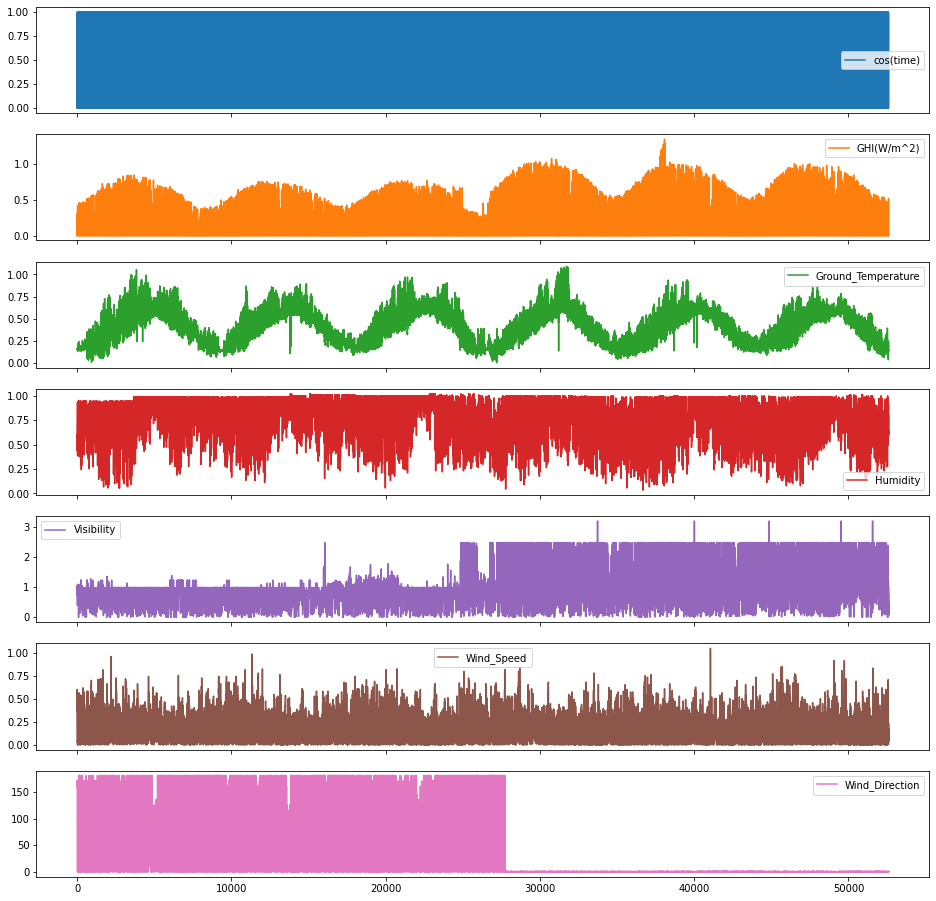

In [26]:
proc_data_dangjin.plot(subplots=True, figsize=(16, 16));

In [27]:
import seaborn as sns
sns.set_style("white")
sns.pairplot(pd.concat([proc_data_dangjin[['cos(time)',
                             'GHI(W/m^2)',
                             'Ground_Temperature',
                             'Humidity',
                             'Visibility',
                             'Wind_Speed',
                             'Wind_Direction']], raw_power_dangjin],
                              axis=1).reset_index(inplace=True, drop=True))


InvalidIndexError: Reindexing only valid with uniquely valued Index objects

## 2. 모델링 및 학습

In [28]:
train_bound = np.where(weather_dataset_dangjin['Time']=='2020-01-01 0:00')[0][0]

In [29]:
# NaN 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(raw_data_dangjin.values)
imp_data_dangjin = imputer.transform(raw_data_dangjin.values)

imputer.fit(raw_data_ulsan.values)
imp_data_ulsan = imputer.transform(raw_data_ulsan.values)

imputer.fit(np.expand_dims(raw_power_dangjin, axis=0))
proc_power_dangjin = imputer.transform(np.expand_dims(raw_power_dangjin, axis=0))

imputer.fit(np.expand_dims(raw_power_warehouse, axis=0))
proc_power_warehouse = imputer.transform(np.expand_dims(raw_power_warehouse, axis=0))

In [30]:
from sklearn.model_selection import train_test_split
dangjin_temp = proc_data_dangjin[:train_bound]
ulsan_temp = proc_data_ulsan[:train_bound]
label_dangjin = np.transpose(proc_power_dangjin)[:train_bound]
label_warehouse = np.transpose(proc_power_warehouse)[:train_bound]
label_ulsan = raw_power_ulsan[:train_bound]
x_train_dangjin, x_test_dangjin, y_train_dangjin, y_test_dangjin = train_test_split(dangjin_temp,
                                                                                   label_dangjin,
                                                                                   test_size = 0.2,
                                                                                   shuffle = False)
x_train_warehouse, x_test_warehouse, y_train_warehouse, y_test_warehouse = train_test_split(dangjin_temp,
                                                                                   label_warehouse,
                                                                                   test_size = 0.2,
                                                                                   shuffle = False)
x_train_ulsan, x_test_ulsan, y_train_ulsan, y_test_ulsan = train_test_split(ulsan_temp,
                                                                           label_ulsan,
                                                                           test_size = 0.2,
                                                                           shuffle = False)
                                                                                                   

In [31]:
print(x_train_dangjin.shape)
print(x_test_dangjin.shape)
print(y_train_dangjin.shape)
print(y_test_dangjin.shape)

(35059, 7)
(8765, 7)
(35059, 1)
(8765, 1)


In [32]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,20))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,150])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,80])
    plt.legend()
    plt.show()

In [203]:
from keras import layers
def build_model_GHI():
    model = keras.Sequential([
                            layers.Dense(256, activation='relu', input_shape=[len(x_train_dangjin.keys())]),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae','mse'])
    return model

In [204]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

EPOCHS = 200
model_dangjin = build_model_GHI()
history_dangjin = model_dangjin.fit(
                    x_train_dangjin,
                    y_train_dangjin.astype(float),
                    epochs=EPOCHS, batch_size = 128, validation_split = 0.2, verbose=2,
                    callbacks=[es,mc])

Epoch 1/200
220/220 - 1s - loss: 135.0499 - mae: 135.0499 - mse: 57998.2383 - val_loss: 90.0915 - val_mae: 90.0915 - val_mse: 25802.2598
Epoch 2/200
220/220 - 1s - loss: 90.3388 - mae: 90.3388 - mse: 29365.5195 - val_loss: 78.6453 - val_mae: 78.6453 - val_mse: 21916.9219
Epoch 3/200
220/220 - 1s - loss: 73.6576 - mae: 73.6576 - mse: 20870.5020 - val_loss: 79.2382 - val_mae: 79.2382 - val_mse: 23024.8184
Epoch 4/200
220/220 - 1s - loss: 73.0647 - mae: 73.0647 - mse: 20528.3750 - val_loss: 75.0738 - val_mae: 75.0738 - val_mse: 20094.5449
Epoch 5/200
220/220 - 1s - loss: 71.1442 - mae: 71.1442 - mse: 19597.6641 - val_loss: 75.1645 - val_mae: 75.1645 - val_mse: 21014.0371
Epoch 6/200
220/220 - 1s - loss: 70.0400 - mae: 70.0400 - mse: 19119.3984 - val_loss: 75.0373 - val_mae: 75.0373 - val_mse: 21226.9590
Epoch 7/200
220/220 - 1s - loss: 69.5914 - mae: 69.5914 - mse: 18833.2773 - val_loss: 74.2226 - val_mae: 74.2226 - val_mse: 20451.4082
Epoch 8/200
220/220 - 0s - loss: 68.7576 - mae: 68.75

Epoch 62/200
220/220 - 0s - loss: 64.1602 - mae: 64.1602 - mse: 16379.2734 - val_loss: 72.5961 - val_mae: 72.5961 - val_mse: 19253.5586
Epoch 63/200
220/220 - 1s - loss: 64.2050 - mae: 64.2050 - mse: 16391.8438 - val_loss: 73.6364 - val_mae: 73.6364 - val_mse: 17577.5547
Epoch 64/200
220/220 - 1s - loss: 64.2103 - mae: 64.2103 - mse: 16336.9805 - val_loss: 73.1806 - val_mae: 73.1806 - val_mse: 17674.1816
Epoch 65/200
220/220 - 1s - loss: 63.9311 - mae: 63.9311 - mse: 16341.7109 - val_loss: 73.3783 - val_mae: 73.3783 - val_mse: 18575.8281
Epoch 66/200
220/220 - 0s - loss: 64.1324 - mae: 64.1324 - mse: 16422.7559 - val_loss: 73.0245 - val_mae: 73.0245 - val_mse: 18947.7656
Epoch 67/200
220/220 - 1s - loss: 64.1242 - mae: 64.1242 - mse: 16322.7656 - val_loss: 72.7671 - val_mae: 72.7671 - val_mse: 18740.0645
Epoch 68/200
220/220 - 1s - loss: 64.1582 - mae: 64.1582 - mse: 16170.4238 - val_loss: 73.1579 - val_mae: 73.1579 - val_mse: 19673.2715
Epoch 69/200
220/220 - 1s - loss: 64.3710 - mae:

In [205]:
es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

EPOCHS = 200
model_warehouse = build_model_GHI()
history_warehouse = model_warehouse.fit(
                    x_train_warehouse.astype(np.float32),
                    y_train_warehouse.astype(np.float32),
                    epochs=EPOCHS, batch_size = 128, validation_split = 0.2, verbose=2,
                    callbacks=[es,mc])

Epoch 1/200
220/220 - 1s - loss: 92.4888 - mae: 92.4888 - mse: 26663.2363 - val_loss: 54.9986 - val_mae: 54.9986 - val_mse: 10117.3564
Epoch 2/200
220/220 - 1s - loss: 56.7467 - mae: 56.7467 - mse: 11717.4629 - val_loss: 47.9867 - val_mae: 47.9867 - val_mse: 8507.6494
Epoch 3/200
220/220 - 0s - loss: 51.1923 - mae: 51.1923 - mse: 9952.8965 - val_loss: 48.7602 - val_mae: 48.7602 - val_mse: 9099.8896
Epoch 4/200
220/220 - 1s - loss: 49.5221 - mae: 49.5221 - mse: 9507.5176 - val_loss: 47.2851 - val_mae: 47.2851 - val_mse: 8055.1602
Epoch 5/200
220/220 - 0s - loss: 48.8121 - mae: 48.8121 - mse: 9250.4443 - val_loss: 47.9901 - val_mae: 47.9901 - val_mse: 8717.5547
Epoch 6/200
220/220 - 0s - loss: 48.3469 - mae: 48.3469 - mse: 9143.6826 - val_loss: 48.3103 - val_mae: 48.3103 - val_mse: 8662.4727
Epoch 7/200
220/220 - 0s - loss: 48.4910 - mae: 48.4910 - mse: 9183.0898 - val_loss: 48.6742 - val_mae: 48.6742 - val_mse: 8839.4785
Epoch 8/200
220/220 - 1s - loss: 48.2591 - mae: 48.2591 - mse: 906

In [215]:
model_ulsan = build_model_GHI()
history_ulsan = model_ulsan.fit(
                    GHI_x_train_ulsan, y_train_ulsan.astype(float),
                    epochs=EPOCHS, batch_size = 128, validation_split = 0.2, verbose=2,
                    callbacks=[es,mc])

NameError: name 'GHI_x_train_ulsan' is not defined

## 3. 평가 및 시각화

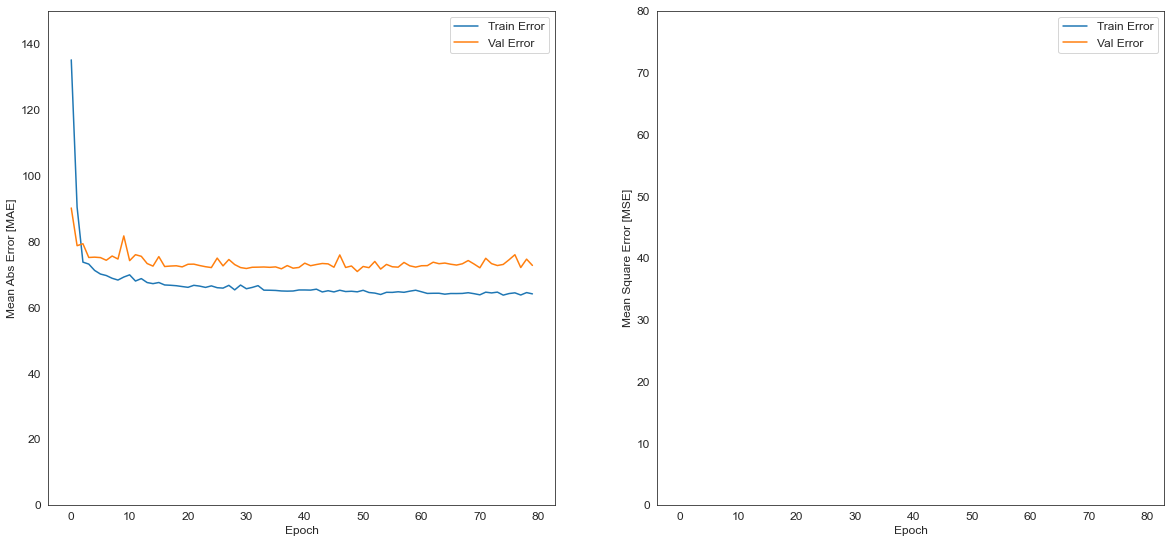

In [206]:
plot_history(history_dangjin) #Adam

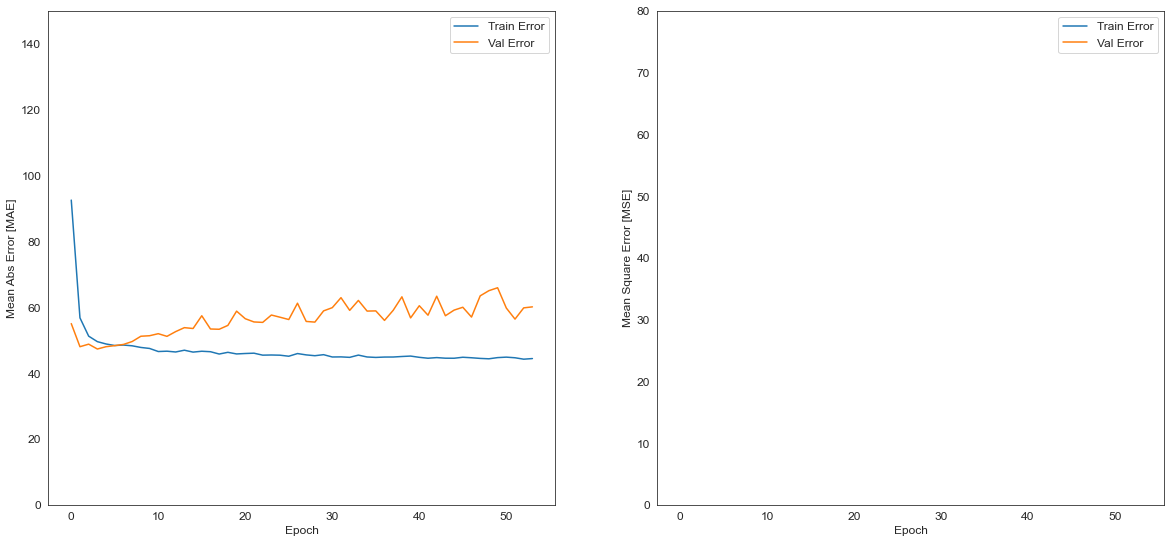

In [207]:
plot_history(history_warehouse) #Adam

In [208]:
#GHI evaluation Adam
loss1, mae1, mse1 = model_dangjin.evaluate(x_test_dangjin, y_test_dangjin.astype(float), verbose=1)
print("당진 test set의 MAE: {:5.4f}".format(mae1))
print("test set MSE: {:5.4f}".format(mse1))

274/274 [==============================] - 0s 1ms/step - loss: 69.6447 - mae: 69.6447 - mse: 17972.5586
당진 test set의 MAE: 69.6447
test set MSE: 17972.5586


In [209]:
#GHI evaluation Adam
loss1, mae1, mse1 = model_warehouse.evaluate(x_test_warehouse, y_test_warehouse.astype(float), verbose=1)
print("당진 test set의 MAE: {:5.4f}".format(mae1))
print("test set MSE: {:5.4f}".format(mse1))

274/274 [==============================] - 0s 1ms/step - loss: 59.2058 - mae: 59.2058 - mse: 13828.0537
당진 test set의 MAE: 59.2058
test set MSE: 13828.0537


In [39]:
#=========SVM 회귀==========#
from sklearn.svm import SVR

#GHI_svm_reg = SVR(kernel = 'rbf',degree=3, C=1000, epsilon = 0.01, verbose = True)
#GHI_svm_reg.fit(x_train_dangjin, y_train_dangjin)

In [132]:
#=========XGBoost 회귀==========#
import xgboost
from xgboost import XGBRegressor
GHI_xgb_reg = XGBRegressor()
GHI_xgb_reg.fit(x_train_dangjin, y_train_dangjin.astype(float))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [133]:
import lightgbm
from lightgbm import LGBMRegressor
GHI_lgbm_reg = LGBMRegressor(boosting_type='gbdt',
                            num_leaves = 256,
                            max_depth = 9,
                            learning_rate = 0.05,
                            n_estimators=100)
GHI_lgbm_reg.fit(x_train_dangjin, y_train_dangjin.astype(float))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\lightgbm\basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(learning_rate=0.05, max_depth=9, num_leaves=256)

In [189]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 1000
    target_idx = pd.DataFrame(sum_answer[sum_answer>=1000*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [190]:
def Evaluate_NMAE_ware(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 700
    target_idx = pd.DataFrame(sum_answer[sum_answer>=700*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

In [210]:
answer_dangjin = raw_power_dangjin[train_bound:]
answer_warehouse = raw_power_warehouse[train_bound:]
answer_ulsan = raw_power_ulsan[train_bound:]
dangjin_2021_01 = proc_data_dangjin[train_bound:]
warehouse_2021_01 = proc_data_dangjin[train_bound:]
ulsan_2021_01 = proc_data_ulsan[train_bound:]
MLP_submission_df = np.squeeze(model_dangjin.predict(dangjin_2021_01))
ware_submission_df = np.squeeze(model_warehouse.predict(warehouse_2021_01))
#MLP_submission_ulsan = np.squeeze(model_ulsan.predict((ulsan_2021_01)))
LGB_submission_df = np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))
#SVM_submission_df = np.squeeze(GHI_svm_reg.predict(GHI_2021_01))
XGB_submission_df = np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [211]:
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(MLP_submission_df)))
print("NMAE, MLP, warehouse :",Evaluate_NMAE_ware(pd.DataFrame(answer_warehouse), pd.DataFrame(ware_submission_df)))

#print("NMAE for ULS :",Evaluate_NMAE(answer_ulsan, MLP_submission_ulsan))
print("NMAE for LGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
#print("NMAE for SVM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(SVM_submission_df)))
print("NMAE for XGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))

NMAE for MLP : 4.318632084217226
NMAE, MLP, warehouse : 8.054132769107982
NMAE for LGB : 5.8487756257097585
NMAE for XGB : 6.480300503433263


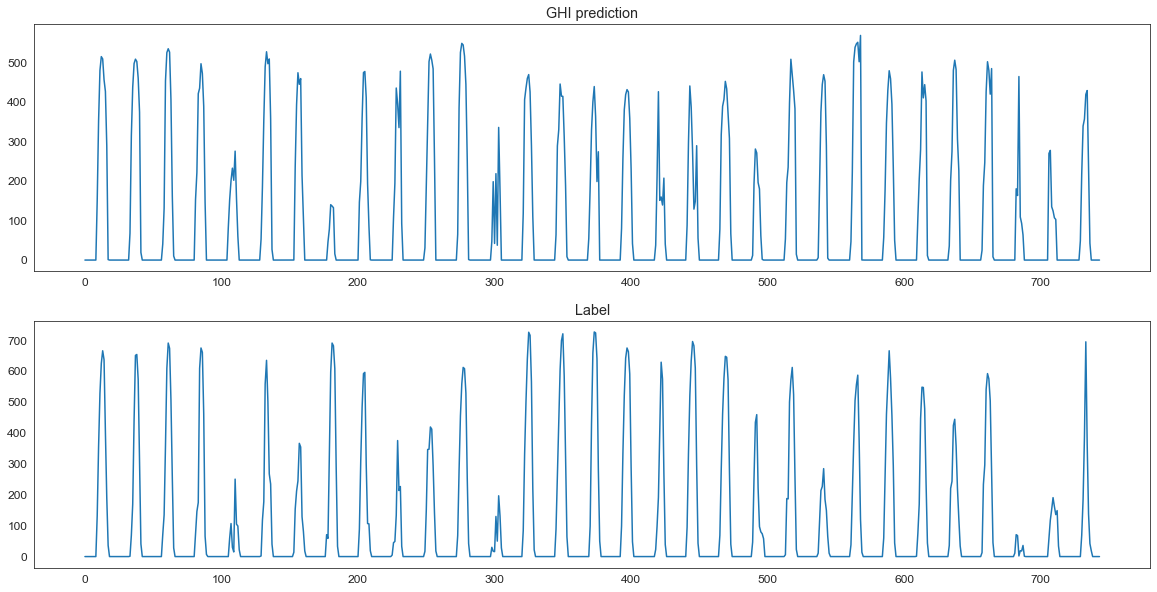

In [149]:
length = 25632-24888
fig = plt.figure(figsize=(20,10))
plt.rc('font', size = 12)
plt.subplot(211)
plt.title('GHI prediction')
plt.plot(range(0,len(dangjin_temp['cos(time)'][-length:])), 
         np.squeeze(model_dangjin.predict(dangjin_2021_01))[-length:])

plt.subplot(212)
plt.title('Label')
plt.plot(range(0,len(dangjin_temp['cos(time)'][-length:])), 
         raw_power_dangjin[-length:])

In [215]:
year = 24*365

NMAE for MLP : 4.318632084217226


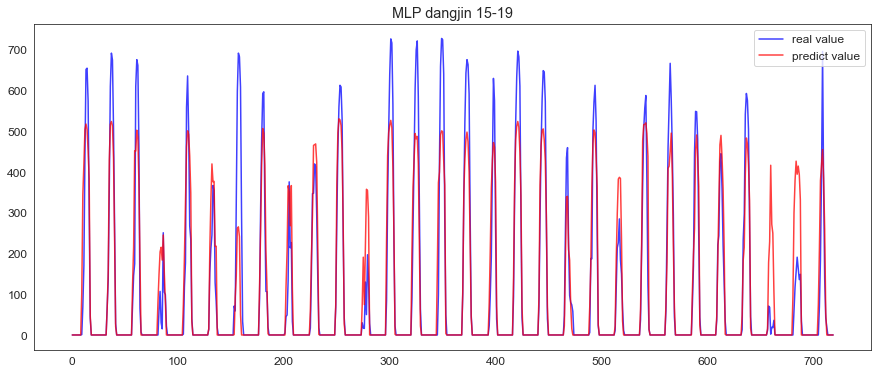

In [230]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-24*30:].reset_index()
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(MLP_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.75, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(dangjin_2021_01))[-24*30:], marker='', color='red', alpha = 0.75, label='predict value')
chart.set_title('MLP dangjin 15-19')
plt.legend(loc = 'best') 

NMAE for MLP : 4.318632084217226


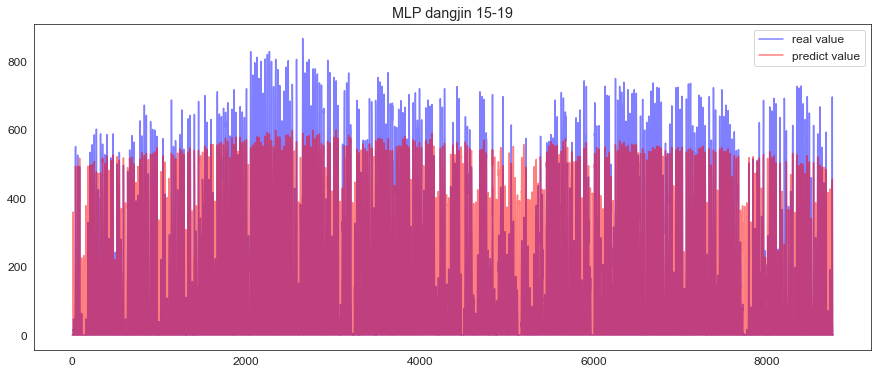

In [233]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(MLP_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('MLP dangjin 15-19')
plt.legend(loc = 'best');

NMAE for LGBM : 5.8487756257097585


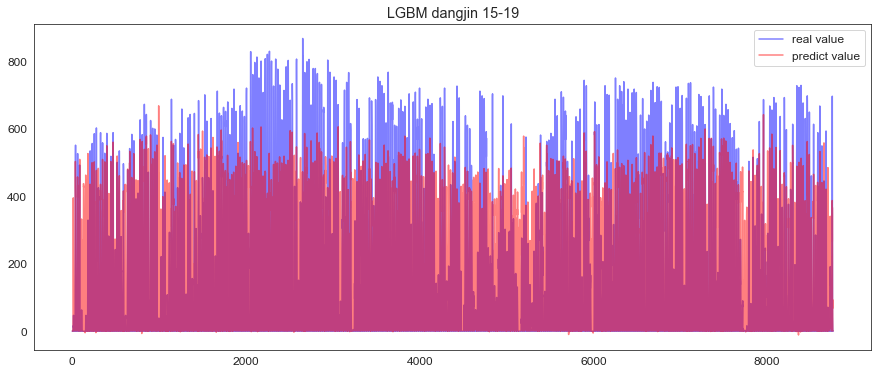

In [232]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for LGBM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.50,
                                                                   label='predict value')
chart.set_title('LGBM dangjin 15-19')
plt.legend(loc = 'best');

NMAE for XGBoost : 6.480300503433263


C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


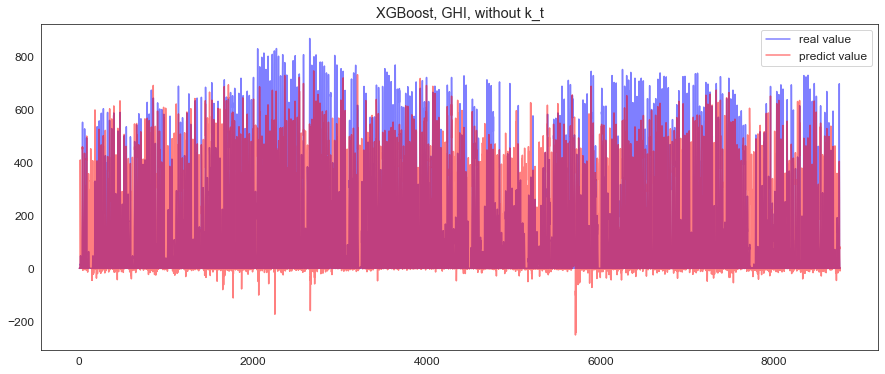

In [227]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for XGBoost :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('XGBoost, GHI, without k_t')
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(211)
sns.lineplot(data=data_dangjin, x= data_dangjin.index, y = 'Power', linewidth = 0.2)

In [289]:
reset['Power']

0      0
1      0
2      0
3      0
4      0
      ..
739    0
740    0
741    0
742    0
743    0
Name: Power, Length: 744, dtype: int64